In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from datetime import datetime
from types import SimpleNamespace
import os
from glob import glob
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import wandb
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import xarray
import pandas as pd
from dataset.dataset import ImageDataset, SingleImageDataset, pickle_read, SeviriDataset
from dataset.normalization import MinMax, ZeroMinMax
from dataset.station_dataset import GroundstationDataset, GroundstationDataset2
from train import get_dataloaders
from lightning.pytorch import Trainer, LightningDataModule
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from models.ConvResNet_Jiang import ConvResNet, ConvResNet_dropout, ConvResNet_batchnormMLP
from models.LightningModule import LitEstimator, LitEstimatorPoint
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm
from utils.plotting import prediction_error_plot, plot_station_locations
from cartopy.mpl.gridliner import (
    LongitudeFormatter,
    LatitudeFormatter,
    LongitudeLocator,
    LatitudeLocator,
)
plt.rcParams['text.usetex'] = False

In [2]:
## Set Up Model

ckpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/4nbyae30/checkpoints/epoch=7-val_loss=0.01023.ckpt'

inference_fn = ckpt_fn.split('checkpoints')[0] + 'inference/'
if not os.path.exists(inference_fn):
    os.mkdir(inference_fn)

config = {
    "batch_size": 2048,
    "patch_size": {
        "x": 15,
        "y": 15,
        "stride_x": 1,
        "stride_y": 1,
    },
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
        "DEM",
    ],
    "y_vars": ["SIS",],
    "x_features": ["dayofyear", "lat", "lon", 'SZA', "AZI",],
    "transform": ZeroMinMax(),
    "target_transform": ZeroMinMax(),
    'max_epochs': 10,
    # Compute related
    'num_workers': 0,
    'ACCELERATOR': "gpu",
    'DEVICES': -1,
    'NUM_NODES': 1,
    'STRATEGY': "ddp",
    'PRECISION': "32",
    'EarlyStopping': {'patience':2},
    'ModelCheckpoint':{'every_n_epochs':1, 'save_top_k':-1}
}
config = SimpleNamespace(**config)

In [70]:
# load checkpoint
estimator = LitEstimatorPoint.load_from_checkpoint(ckpt_fn)

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'metric' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric'])`.


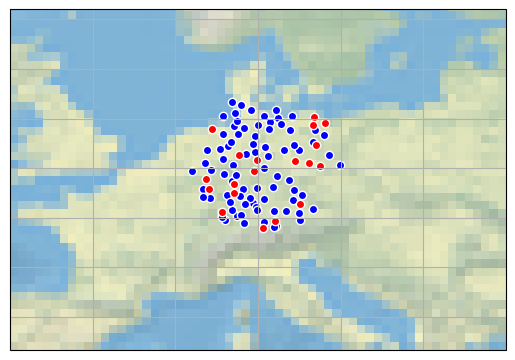

In [5]:
zarr_fns = glob('../../ZARR/DWD/DWD_SOLAR_*.zarr')
station_names = [int(os.path.basename(fn).split('SOLAR_')[-1].split('.')[0]) for fn in zarr_fns]
index = xarray.open_dataset('/scratch/snx3000/kschuurm/DATA/DWD/netcdf/DWD_SOLAR_index.nc')
index = index.sel(station_id=station_names)

# train_id, valid_id = torch.utils.data.random_split(station_names, [.8, .2])
# print(list(train_id), list(valid_id))

train_id = [15000, 2638, 662, 342, 691, 4104, 1684, 5426, 1766, 3167, 596, 880, 1346, 4271, 1550, 3196, 5792, 2485, 856, 1468, 3287, 4336, 701, 3126, 891, 1078, 4393, 963, 5705, 5546, 7368, 4887, 164, 704, 2261, 656, 2559, 6197, 3513, 3032, 7351, 430, 1443, 2907, 5856, 5404, 6163, 2483, 3268, 2601, 15444, 13674, 7374, 5480, 7367, 4745, 2014, 4625, 5100, 3761, 460, 7369, 3086, 3366, 282, 591, 1639, 232, 4177, 7370, 2667, 4928, 2712, 4466, 5397, 5516, 1975, 1503, 2115, 1605]
valid_id = [1757, 5109, 953, 3028, 2290, 5906, 2171, 427, 2932, 2812, 5839, 1691, 3811, 1420, 5142, 4911, 3660, 3730, 1048]

index_train = index.sel(station_id=train_id); index_valid = index.sel(station_id=valid_id)

a = index_train.plot.scatter(x='lon', y='lat', c='b', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
index_valid.plot.scatter(x='lon', y='lat', c='r', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
a.axes.gridlines()
a.axes.stock_img()
a.axes.set_extent([-5, 25, 40, 60])
plt.show()

In [7]:
valid_datasets = [GroundstationDataset2(f'../../ZARR/DWD/DWD_SOLAR_{str(x).zfill(5)}.zarr', config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], config.transform, config.target_transform, subset_year=2016)
            for x in tqdm(valid_id)]
valid_dataset = torch.utils.data.ConcatDataset(valid_datasets)


100%|██████████| 19/19 [02:29<00:00,  7.86s/it]


In [8]:
train_datasets = [GroundstationDataset2(f'../../ZARR/DWD/DWD_SOLAR_{str(x).zfill(5)}.zarr', config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], config.transform, config.target_transform)
            for x in tqdm(train_id)]
train_dataset = torch.utils.data.ConcatDataset(train_datasets)


100%|██████████| 80/80 [10:02<00:00,  7.53s/it]


In [4]:
zarr_fns = glob('../../ZARR/IEA_PVPS/IEA_PVPS-*.zarr')
station_names_bsrn = [os.path.basename(fn).split('IEA_PVPS-')[-1].split('.')[0] for fn in zarr_fns]
bsrn_datasets = [GroundstationDataset2(f'../../ZARR/IEA_PVPS/IEA_PVPS-{x}.zarr', 
                                        config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], 
                                        config.transform, config.target_transform, sarah_idx_only=True)
                            for x in tqdm(station_names_bsrn)]
bsrn_dataset = torch.utils.data.ConcatDataset(bsrn_datasets)

100%|██████████| 14/14 [01:14<00:00,  5.30s/it]


In [57]:

class DataModule(LightningDataModule):

  def __init__(self, train_dataset, val_dataset,  bsrn_dataset, batch_size = 2):

    super(DataModule, self).__init__()
    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    self.bsrn_dataset = bsrn_dataset
    self.batch_size = batch_size
  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True)
  
  def val_dataloader(self):
    val_loader1 = DataLoader(self.val_dataset, batch_size = self.batch_size, shuffle = False)
    val_loader2 = DataLoader(self.bsrn_dataset, batch_size = self.batch_size, shuffle = False)
    return [val_loader1, val_loader2]

dm = DataModule(train_dataset, valid_dataset, bsrn_dataset, config.batch_size)


In [68]:

wandb_logger = WandbLogger(name='freeze MLP 0.1train parloss', project="SIS_point_estimation_groundstation")

mc_sarah = ModelCheckpoint(
        monitor='val_loss/dataloader_idx_0', 
        save_top_k = -1,
        # filename='{epoch}-{val_loss:.5f}'
    ) 

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=1,
    accelerator='gpu',
    precision=config.PRECISION,
    callbacks=[mc_sarah],
    log_every_n_steps=50,
    num_sanity_val_steps=0,
    max_time="00:1:30:00",
    val_check_interval=.1,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [67]:
for name, par in estimator.model.mlp.named_parameters():
    print(name, par.shape, par.requires_grad)

0.weight torch.Size([256, 261]) False
0.bias torch.Size([256]) False
1.weight torch.Size([256]) False
1.bias torch.Size([256]) False
3.weight torch.Size([64, 256]) False
3.bias torch.Size([64]) False
4.weight torch.Size([64]) False
4.bias torch.Size([64]) False
6.weight torch.Size([1, 64]) False
6.bias torch.Size([1]) False


In [71]:
for par in estimator.model.mlp.parameters():
    par.requires_grad = False
    

estimator.set_reference_parameters([par.clone().detach() for par in estimator.model.parameters()])
estimator.parameter_loss = True
estimator.alpha = 3000

In [78]:
trainer.validate(estimator, dm)
trainer.fit(estimator, dm)

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     MeanAbsoluteError     │     62.27632141113281     │     62.27632141113281     │
│     MeanSquaredError      │     8073.39013671875      │     8073.39013671875      │
│          R2Score          │    0.8939480781555176     │    0.8939480781555176     │
│         val_loss          │   0.026664787903428078    │   0.022715188562870026    │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory ./SIS_point_estimation_groundstation/b4t6pdgz/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                    | Params
-------------------------------------------------------------
0 | model            | ConvResNet_batchnormMLP | 4.2 M 
1 | metric           | MeanSquaredError        | 0     
2 | other_metrics    | MetricCollection        | 0     
3 | parameter_metric | MeanSquaredError        | 0     
----------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

MisconfigurationException: ReduceLROnPlateau conditioned on metric val_loss which is not available. Available metrics are: ['par_loss', 'loss', 'loss_step', 'val_loss/dataloader_idx_0', 'val_loss/dataloader_idx_1', 'MeanSquaredError', 'MeanAbsoluteError', 'R2Score', 'loss_epoch']. Condition can be set using `monitor` key in lr scheduler dict

In [24]:
from train import get_dataloaders

estimator = LitEstimatorPoint.load_from_checkpoint('/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation_groundstation/drvowqn4/checkpoints/epoch=0-val_loss=0.01659.ckpt')

_, valid_dataloader = get_dataloaders(config)
trainer.validate(estimator, dataloaders=valid_dataloader)

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'metric' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric'])`.
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


sampler setup : 9.664 seconds


Validation: |          | 0/? [00:00<?, ?it/s]

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [83]:
wandb_logger.experiment.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MeanAbsoluteError,▅▁▁▃▃▅▇▆▅▇▇█▆▆▆▄
MeanSquaredError,▂▁▁▁▁▂▇▆▅▇▇█▆▅▆▃
R2Score,▇████▇▂▃▄▂▂▁▃▄▃▆
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_step,▄▃▃▁▂▁▁▃▃▂▁▂▂█▆▆▆▅▄▅▅▄▅▅▆▆▄▄▅▅▅▅▄▅▅▆▆▅▅▄
par_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▇▇▇▇▇██▇▇▇▇▇▇▇▇▇▇▇██▇▇██▇
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss/dataloader_idx_0,█▂▁▂▁█▂▂▃▃▃▃▃▃▃▃
val_loss/dataloader_idx_1,▂▁▁▁▁▂▅▆▅▇▇█▆▅▆▃
MeanAbsoluteError,58.00253
MeanSquaredError,8972.91211


# Bias correction

In [5]:
from torchmetrics import MeanAbsoluteError, MeanMetric
from train import get_dataloaders

wandb_logger = WandbLogger(name='freeze MLP bias correction, parloss', project="SIS_point_estimation_groundstation")

mc_sarah = ModelCheckpoint(
        monitor='val_loss', 
        save_top_k = 10,
        filename='{epoch}-{val_loss:.5f}'
    ) 

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=1,
    accelerator='gpu',
    precision=config.PRECISION,
    callbacks=[mc_sarah],
    log_every_n_steps=500,
    num_sanity_val_steps=0,
    max_time="00:3:00:00",
    val_check_interval=.001,
)

estimator = LitEstimatorPoint.load_from_checkpoint('../train/SIS_point_estimation_groundstation/9wa4331x/checkpoints/epoch=0-step=840.ckpt')
# estimator.set_reference_parameters([par.clone().detach() for par in estimator.model.parameters()])
# estimator.parameter_loss = True
# estimator.alpha = 3000
val_dataloader = DataLoader(bsrn_dataset, batch_size=config.batch_size, shuffle=False)
train_dataloader, _ = get_dataloaders(config)

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'metric' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric'])`.


sampler setup : 8.527 seconds


In [159]:
for name, par in estimator.model.named_parameters():
    if 'bias' not in  name:
        par.requires_grad = False
    print(name, par.shape, par.requires_grad)

conv1.0.weight torch.Size([64, 12, 3, 3]) False
conv1.0.bias torch.Size([64]) True
conv1.1.weight torch.Size([64]) False
conv1.1.bias torch.Size([64]) True
conv2.0.weight torch.Size([64, 64, 3, 3]) False
conv2.0.bias torch.Size([64]) True
conv2.1.weight torch.Size([64]) False
conv2.1.bias torch.Size([64]) True
resblocks1.0.conv1.0.weight torch.Size([128, 64, 3, 3]) False
resblocks1.0.conv1.0.bias torch.Size([128]) True
resblocks1.0.conv1.1.weight torch.Size([128]) False
resblocks1.0.conv1.1.bias torch.Size([128]) True
resblocks1.0.conv2.0.weight torch.Size([128, 128, 3, 3]) False
resblocks1.0.conv2.0.bias torch.Size([128]) True
resblocks1.0.conv2.1.weight torch.Size([128]) False
resblocks1.0.conv2.1.bias torch.Size([128]) True
resblocks1.1.conv1.0.weight torch.Size([128, 128, 3, 3]) False
resblocks1.1.conv1.0.bias torch.Size([128]) True
resblocks1.1.conv1.1.weight torch.Size([128]) False
resblocks1.1.conv1.1.bias torch.Size([128]) True
resblocks1.1.conv2.0.weight torch.Size([128, 128, 

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: krschuurman. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                    | Params
-------------------------------------------------------------
0 | model            | ConvResNet_batchnormMLP | 4.2 M 
1 | metric           | MeanSquaredError        | 0     
2 | other_metrics    | MetricCollection        | 0     
3 | parameter_metric | MeanSquaredError        | 0     
-------------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.761    Total estimated model params size (MB)
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/trainer

Training: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([472])
zeros in output tensor([178])
zeros in output tensor([39])
zeros in output tensor([718])
zeros in output tensor([548])
zeros in output tensor([40])
zeros in output tensor([143])
zeros in output tensor([567])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([616])
zeros in output tensor([72])
zeros in output tensor([19])
zeros in output tensor([215])
zeros in output tensor([60])
zeros in output tensor([58])
zeros in output tensor([199])
zeros in output tensor([754])
zeros in output tensor([756])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([184])
zeros in output tensor([163])
zeros in output tensor([636])
zeros in output tensor([59])
zeros in output tensor([274])
zeros in output tensor([549])
zeros in output tensor([200])
zeros in output tensor([383])
zeros in output tensor([430])
zeros in output tensor([3])
zeros in output tensor([30])
zeros in output tensor([6])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([254])
zeros in output tensor([744])
zeros in output tensor([114])
zeros in output tensor([873])
zeros in output tensor([160])
zeros in output tensor([122])
zeros in output tensor([565])
zeros in output tensor([12])
zeros in output tensor([611])
zeros in output tensor([791])
zeros in output tensor([32])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([198])
zeros in output tensor([423])
zeros in output tensor([214])
zeros in output tensor([398])
zeros in output tensor([177])
zeros in output tensor([81])
zeros in output tensor([6])
zeros in output tensor([346])
zeros in output tensor([78])
zeros in output tensor([752])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([208])
zeros in output tensor([198])
zeros in output tensor([63])
zeros in output tensor([73])
zeros in output tensor([669])
zeros in output tensor([507])
zeros in output tensor([409])
zeros in output tensor([758])
zeros in output tensor([442])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([5])
zeros in output tensor([584])
zeros in output tensor([103])
zeros in output tensor([15])
zeros in output tensor([329])
zeros in output tensor([785])
zeros in output tensor([138])
zeros in output tensor([283])
zeros in output tensor([287])
zeros in output tensor([146])
zeros in output tensor([123])
zeros in output tensor([192])
zeros in output tensor([313])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([470])
zeros in output tensor([57])
zeros in output tensor([301])
zeros in output tensor([576])
zeros in output tensor([22])
zeros in output tensor([753])
zeros in output tensor([838])
zeros in output tensor([375])
zeros in output tensor([902])
zeros in output tensor([872])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([1])
zeros in output tensor([775])
zeros in output tensor([159])
zeros in output tensor([31])
zeros in output tensor([264])
zeros in output tensor([9])
zeros in output tensor([653])
zeros in output tensor([806])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([226])
zeros in output tensor([235])
zeros in output tensor([626])
zeros in output tensor([327])
zeros in output tensor([170])
zeros in output tensor([343])
zeros in output tensor([142])
zeros in output tensor([897])
zeros in output tensor([116])
zeros in output tensor([88])


Validation: |          | 0/? [00:00<?, ?it/s]

/scratch/snx3000/kschuurm/irradiance_estimation/utils/plotting.py:288: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), subplot_kw={'projection': proj})
/scratch/snx3000/kschuurm/irradiance_estimation/utils/plotting.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 8))


zeros in output tensor([248])
zeros in output tensor([666])
zeros in output tensor([787])
zeros in output tensor([595])
zeros in output tensor([384])
zeros in output tensor([35])
zeros in output tensor([15])
zeros in output tensor([754])
zeros in output tensor([3])
zeros in output tensor([466])
zeros in output tensor([221])
zeros in output tensor([123])


Validation: |          | 0/? [00:00<?, ?it/s]

/scratch/snx3000/kschuurm/irradiance_estimation/utils/plotting.py:237: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))


zeros in output tensor([449])
zeros in output tensor([348])
zeros in output tensor([915])
zeros in output tensor([61])
zeros in output tensor([614])
zeros in output tensor([74])
zeros in output tensor([174])
zeros in output tensor([433])
zeros in output tensor([833])
zeros in output tensor([6])
zeros in output tensor([482])
zeros in output tensor([1])
zeros in output tensor([125])
zeros in output tensor([105])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([547])
zeros in output tensor([8])
zeros in output tensor([216])
zeros in output tensor([161])
zeros in output tensor([55])
zeros in output tensor([163])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([178])
zeros in output tensor([23])
zeros in output tensor([869])
zeros in output tensor([227])
zeros in output tensor([16])
zeros in output tensor([526])
zeros in output tensor([1])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([314])
zeros in output tensor([451])
zeros in output tensor([12])
zeros in output tensor([532])
zeros in output tensor([175])
zeros in output tensor([86])
zeros in output tensor([208])
zeros in output tensor([156])
zeros in output tensor([20])
zeros in output tensor([370])
zeros in output tensor([771])
zeros in output tensor([382])
zeros in output tensor([330])
zeros in output tensor([455])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([23])
zeros in output tensor([407])
zeros in output tensor([1])
zeros in output tensor([424])
zeros in output tensor([324])
zeros in output tensor([2])
zeros in output tensor([51])
zeros in output tensor([605])
zeros in output tensor([626])
zeros in output tensor([896])
zeros in output tensor([124])
zeros in output tensor([99])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([377])
zeros in output tensor([254])
zeros in output tensor([508])
zeros in output tensor([293])
zeros in output tensor([214])
zeros in output tensor([3])
zeros in output tensor([422])
zeros in output tensor([221])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([168])
zeros in output tensor([142])
zeros in output tensor([671])
zeros in output tensor([772])
zeros in output tensor([429])
zeros in output tensor([6])
zeros in output tensor([40])
zeros in output tensor([7])
zeros in output tensor([160])
zeros in output tensor([736])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([4])
zeros in output tensor([267])
zeros in output tensor([203])
zeros in output tensor([340])
zeros in output tensor([6])
zeros in output tensor([4])
zeros in output tensor([43])
zeros in output tensor([634])
zeros in output tensor([589])
zeros in output tensor([608])
zeros in output tensor([74])
zeros in output tensor([839])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([852])
zeros in output tensor([114])
zeros in output tensor([15])
zeros in output tensor([702])
zeros in output tensor([92])
zeros in output tensor([683])
zeros in output tensor([36])
zeros in output tensor([771])
zeros in output tensor([499])
zeros in output tensor([658])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([862])
zeros in output tensor([261])
zeros in output tensor([762])
zeros in output tensor([30])
zeros in output tensor([182])
zeros in output tensor([52])
zeros in output tensor([711])
zeros in output tensor([718])
zeros in output tensor([410])
zeros in output tensor([41])
zeros in output tensor([379])
zeros in output tensor([474])
zeros in output tensor([312])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([438])
zeros in output tensor([769])
zeros in output tensor([456])
zeros in output tensor([100])
zeros in output tensor([246])
zeros in output tensor([222])
zeros in output tensor([781])
zeros in output tensor([351])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([571])
zeros in output tensor([810])
zeros in output tensor([617])
zeros in output tensor([66])
zeros in output tensor([69])
zeros in output tensor([367])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([12])
zeros in output tensor([155])
zeros in output tensor([469])
zeros in output tensor([517])
zeros in output tensor([424])
zeros in output tensor([45])
zeros in output tensor([670])
zeros in output tensor([65])
zeros in output tensor([258])
zeros in output tensor([6])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([693])
zeros in output tensor([171])
zeros in output tensor([63])
zeros in output tensor([31])
zeros in output tensor([534])
zeros in output tensor([612])
zeros in output tensor([622])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([109])
zeros in output tensor([35])
zeros in output tensor([652])
zeros in output tensor([18])
zeros in output tensor([397])
zeros in output tensor([291])
zeros in output tensor([329])
zeros in output tensor([751])
zeros in output tensor([299])
zeros in output tensor([468])
zeros in output tensor([716])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([120])
zeros in output tensor([705])
zeros in output tensor([196])
zeros in output tensor([384])
zeros in output tensor([310])
zeros in output tensor([262])
zeros in output tensor([137])
zeros in output tensor([34])
zeros in output tensor([2])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([428])
zeros in output tensor([443])
zeros in output tensor([858])
zeros in output tensor([13])
zeros in output tensor([18])
zeros in output tensor([846])
zeros in output tensor([228])
zeros in output tensor([757])
zeros in output tensor([295])
zeros in output tensor([599])
zeros in output tensor([208])
zeros in output tensor([210])
zeros in output tensor([21])
zeros in output tensor([310])
zeros in output tensor([511])
zeros in output tensor([773])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([255])
zeros in output tensor([505])
zeros in output tensor([67])
zeros in output tensor([667])
zeros in output tensor([24])
zeros in output tensor([502])
zeros in output tensor([2])
zeros in output tensor([269])
zeros in output tensor([304])


Validation: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([68])
zeros in output tensor([64])
zeros in output tensor([185])


/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


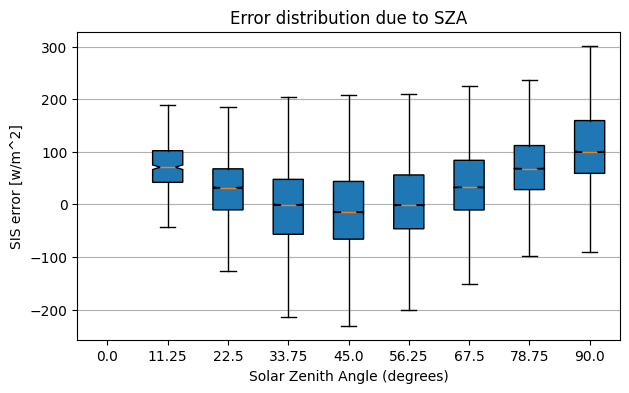

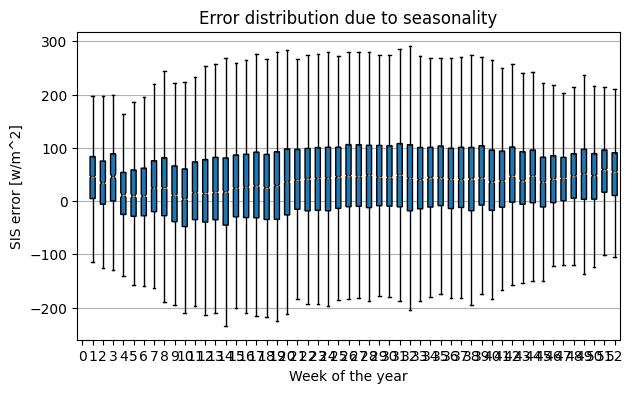

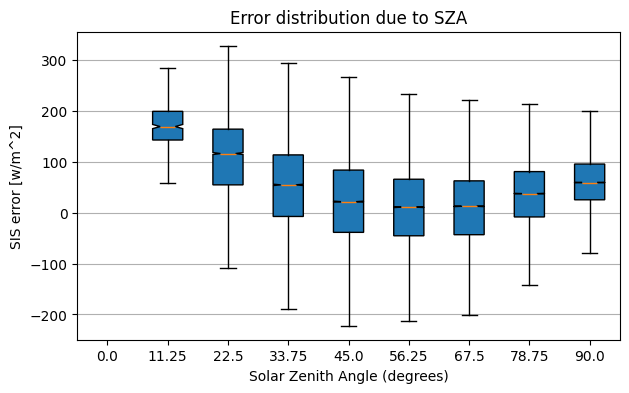

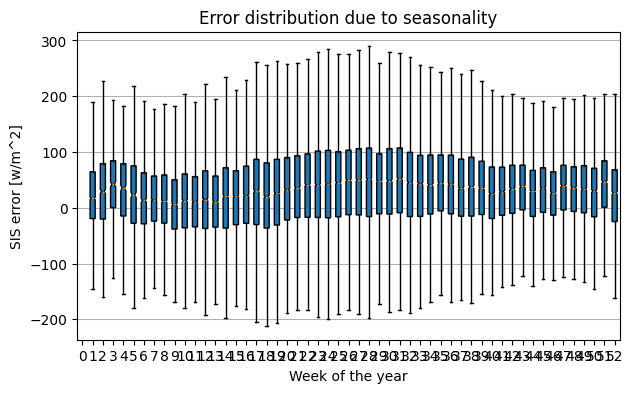

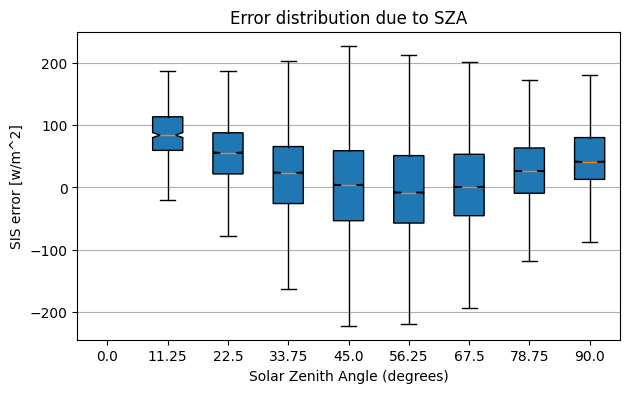

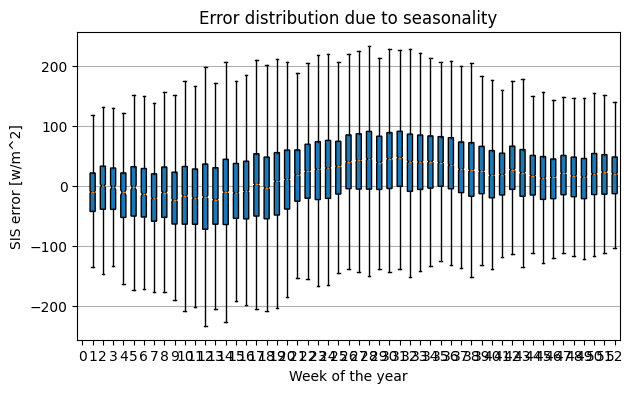

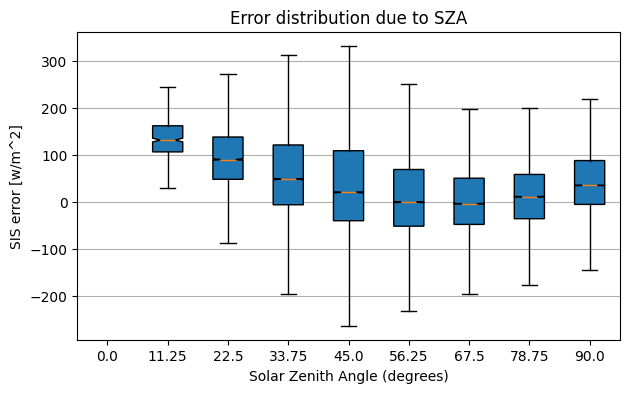

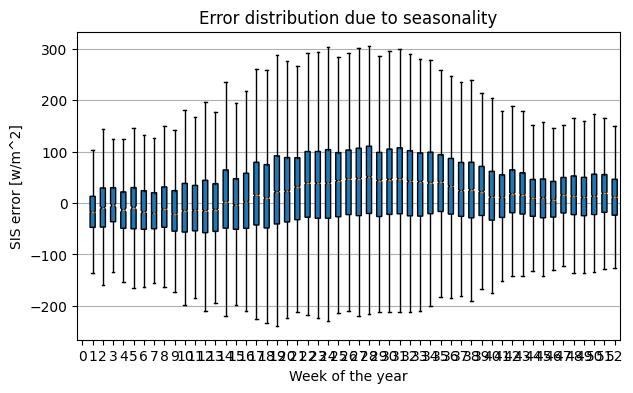

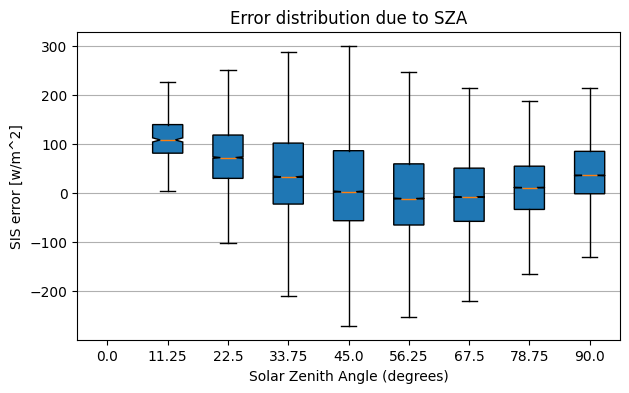

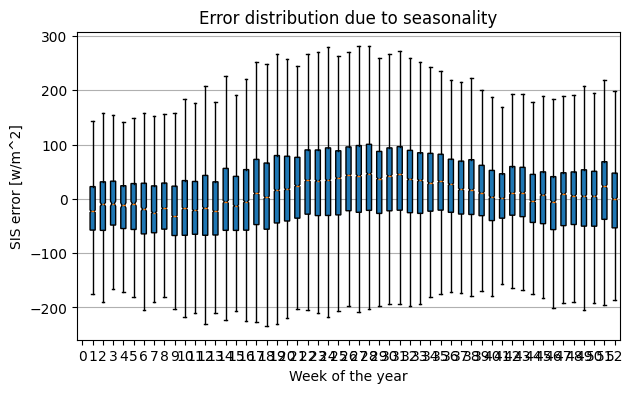

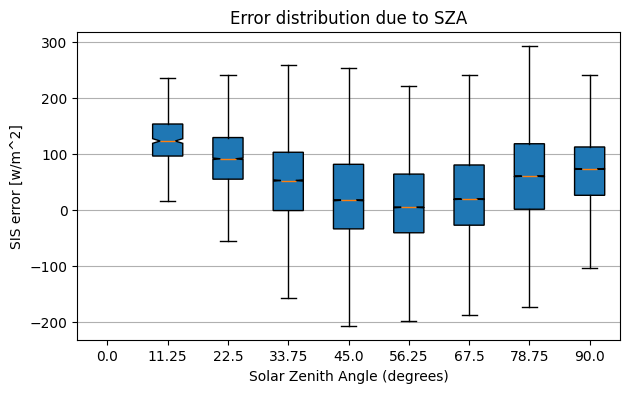

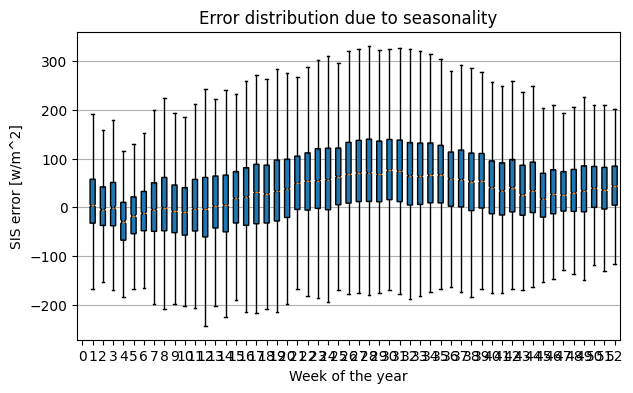

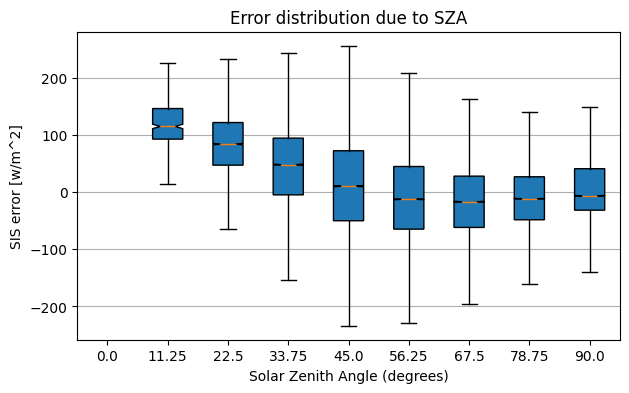

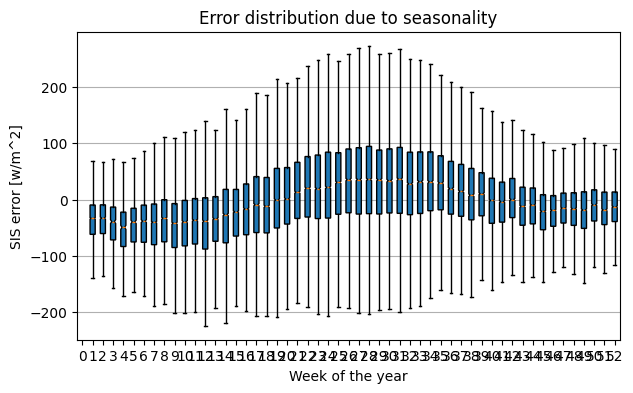

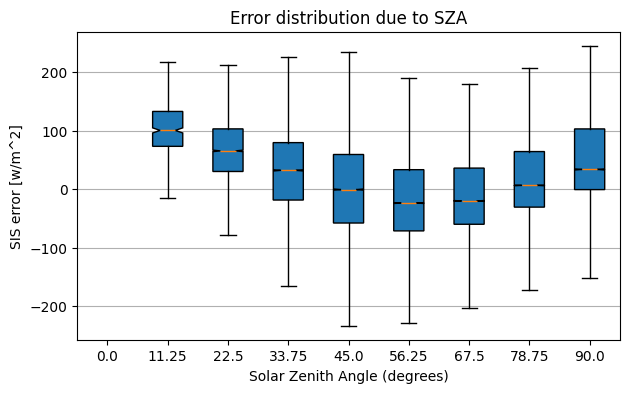

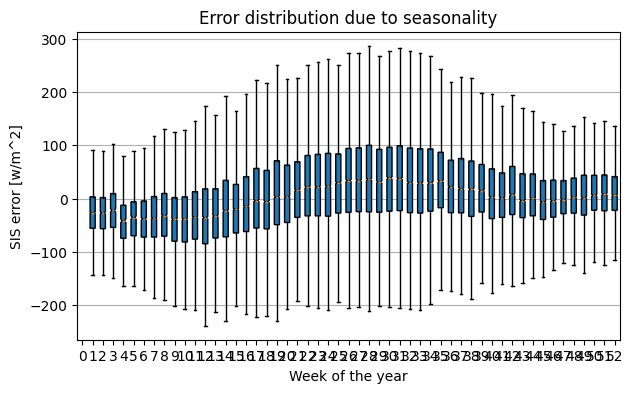

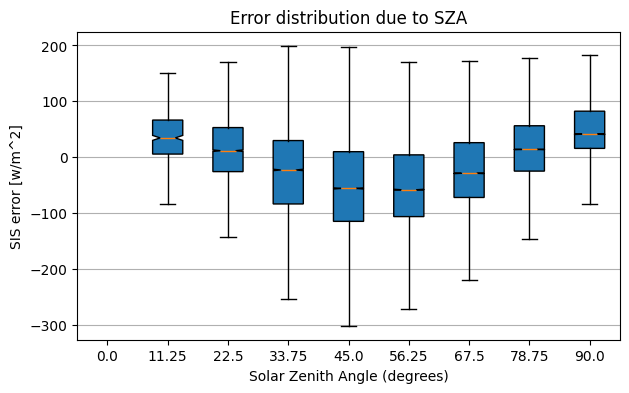

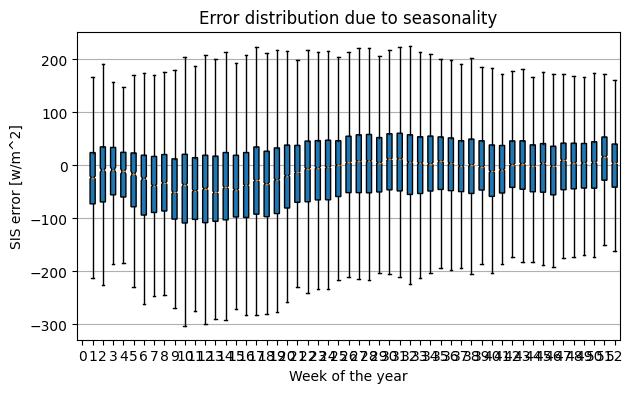

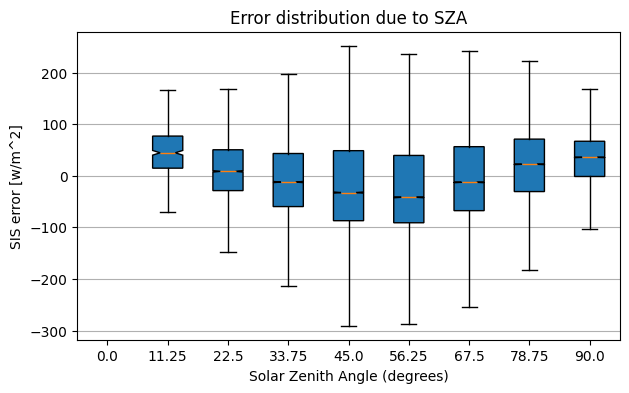

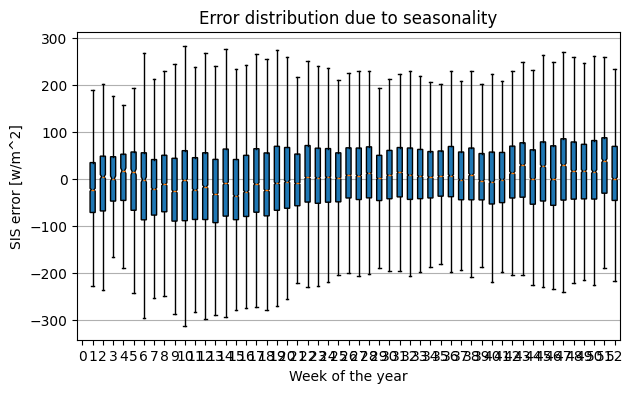

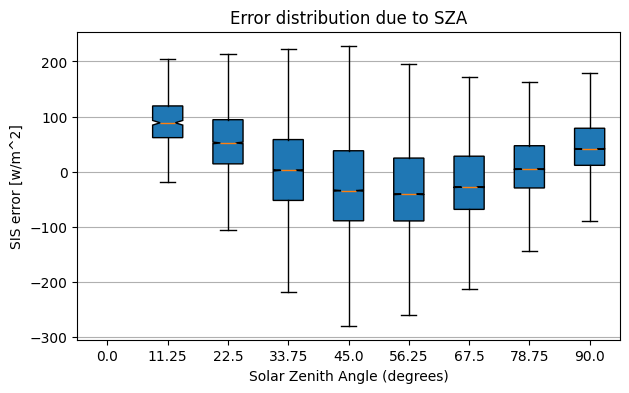

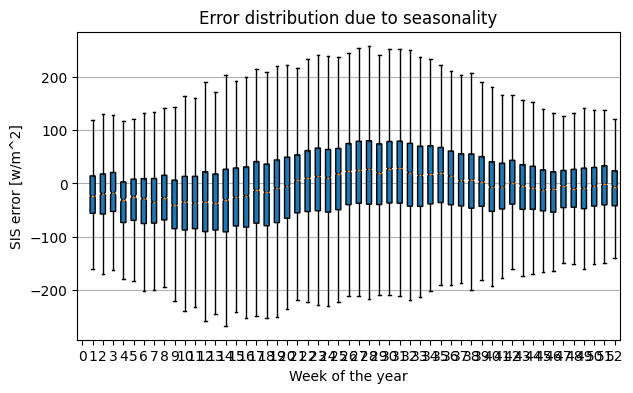

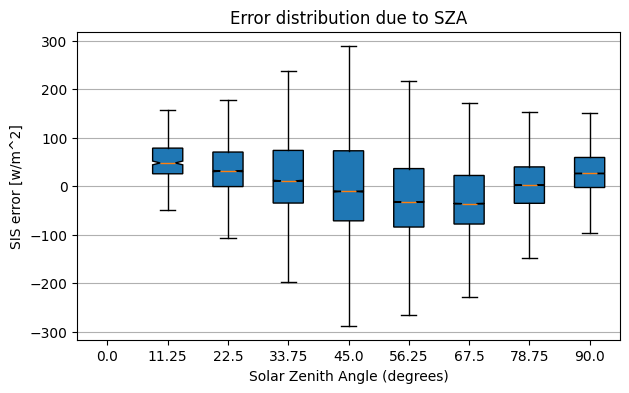

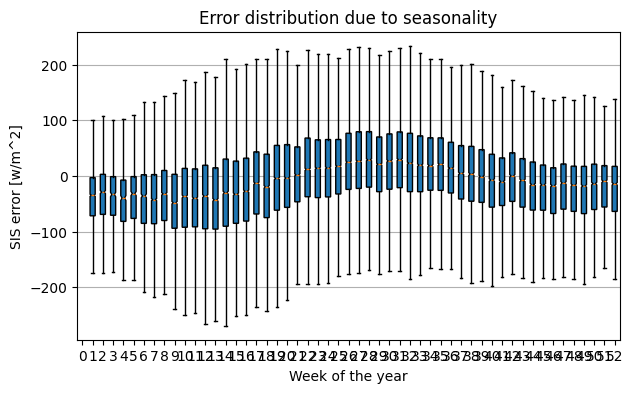

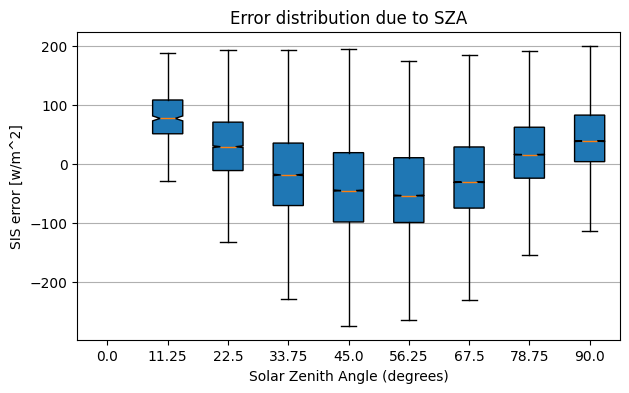

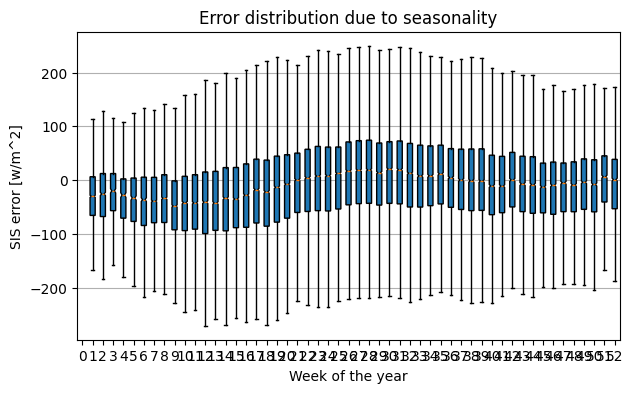

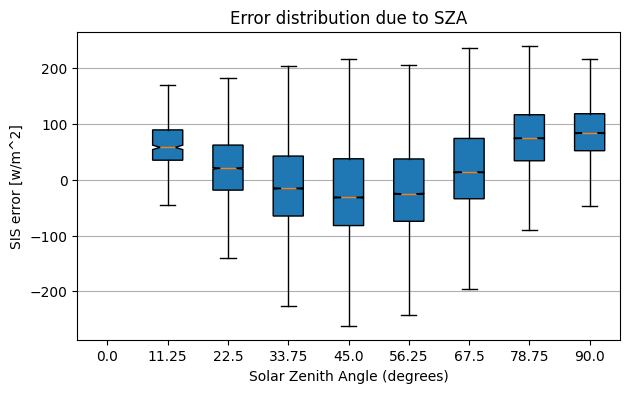

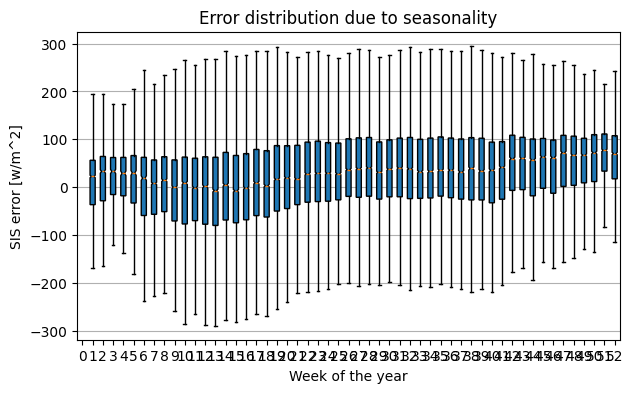

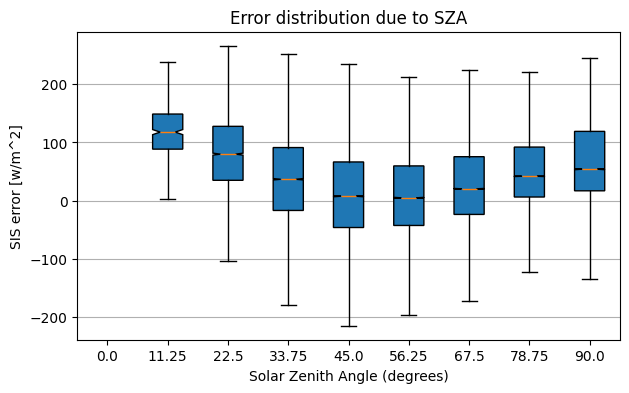

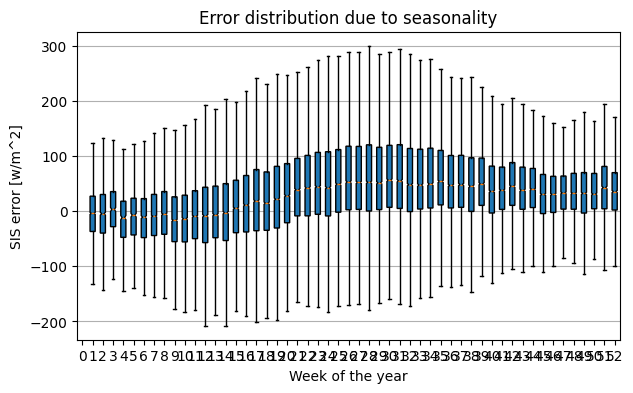

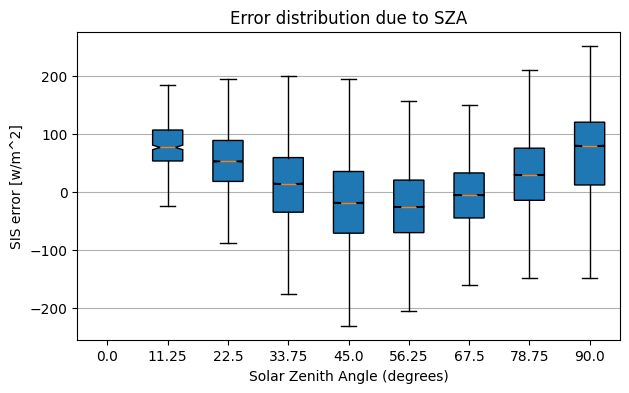

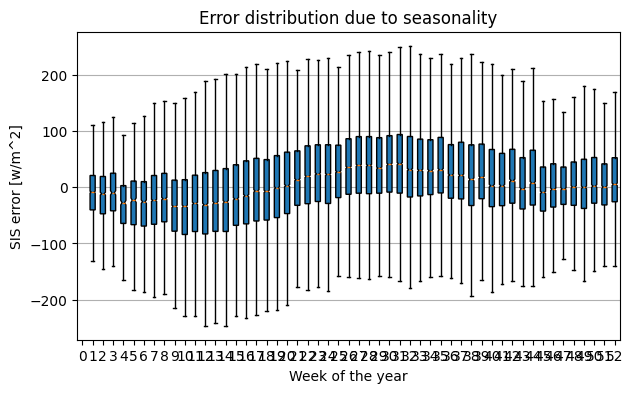

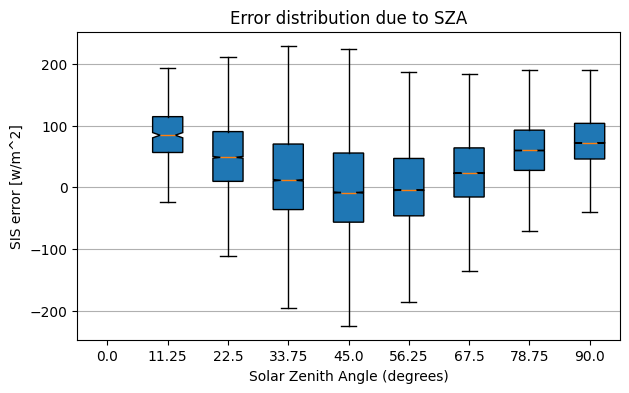

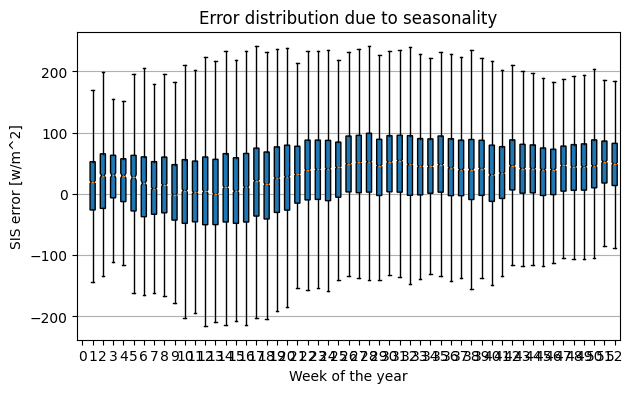

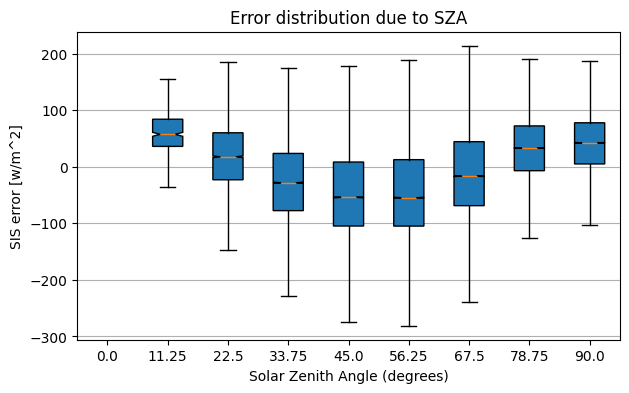

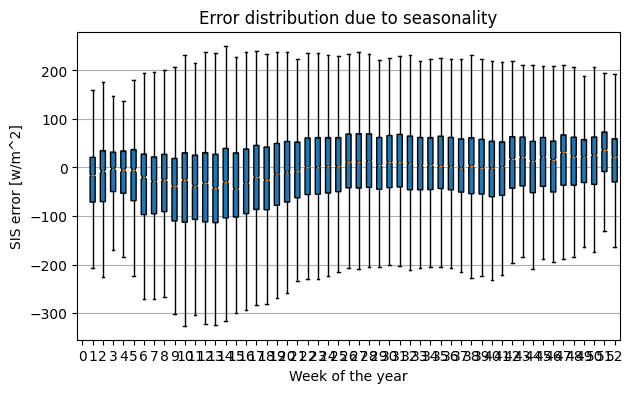

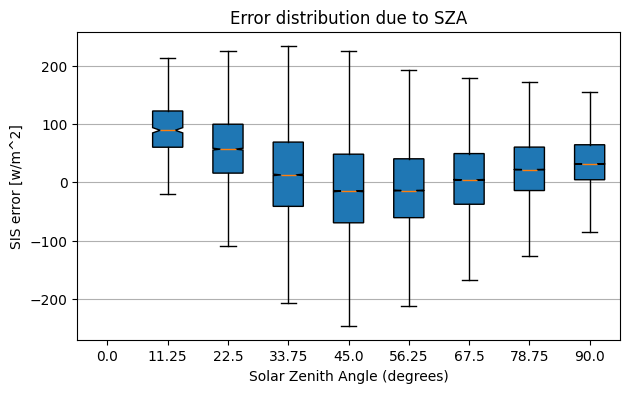

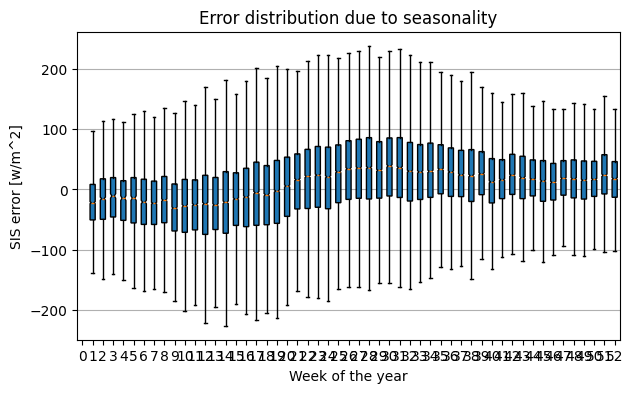

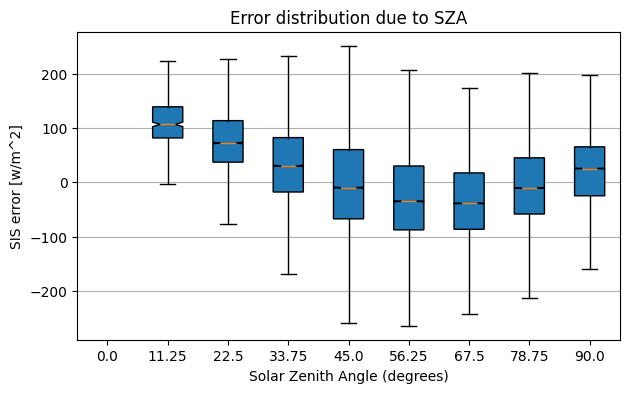

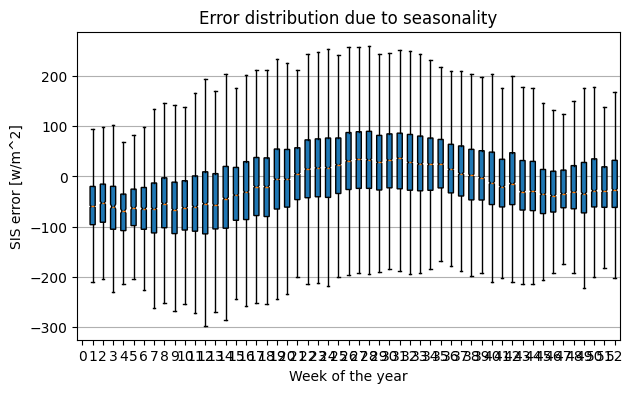

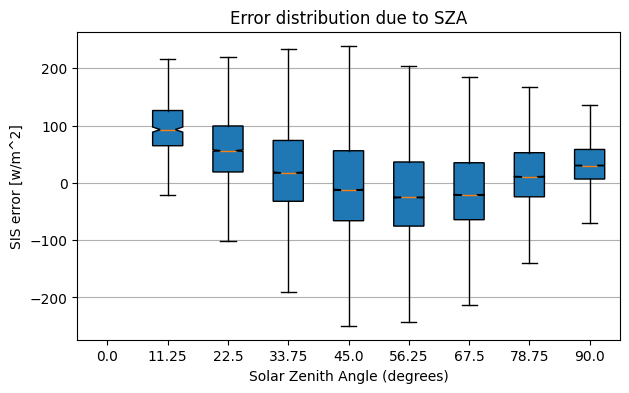

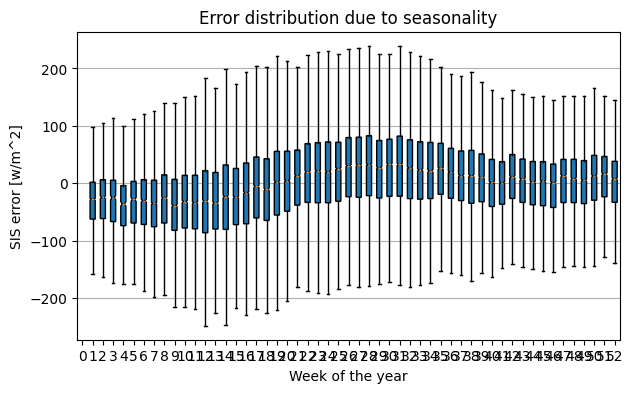

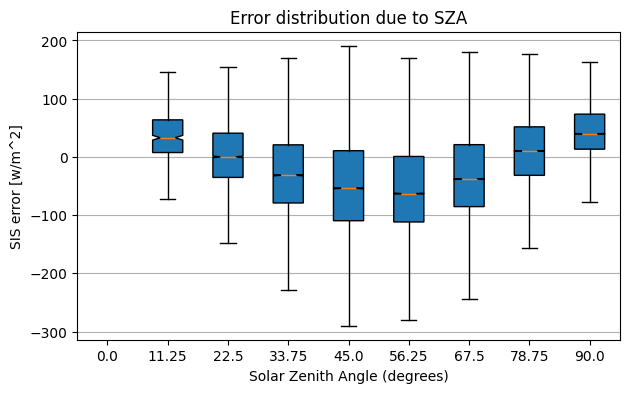

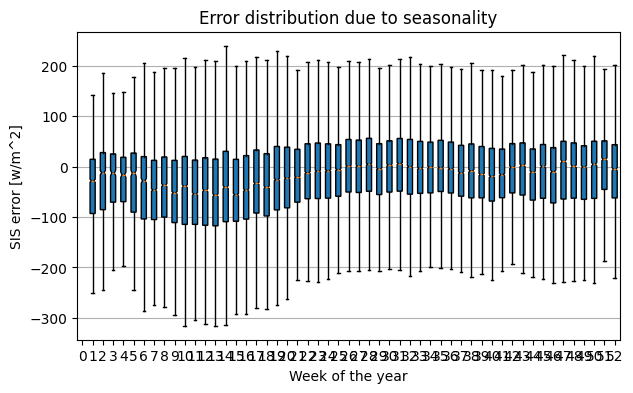

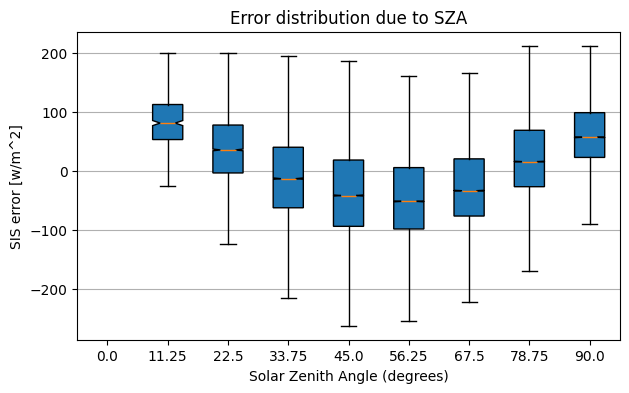

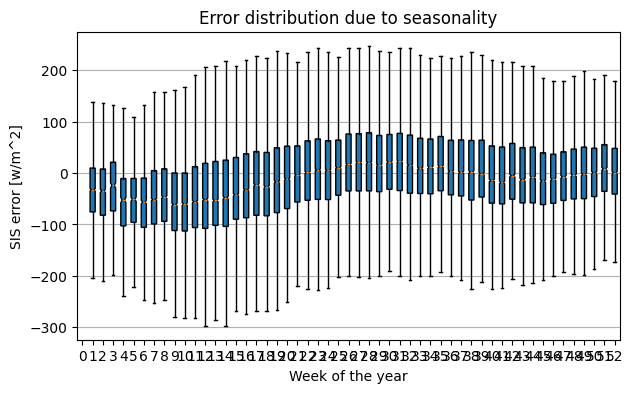

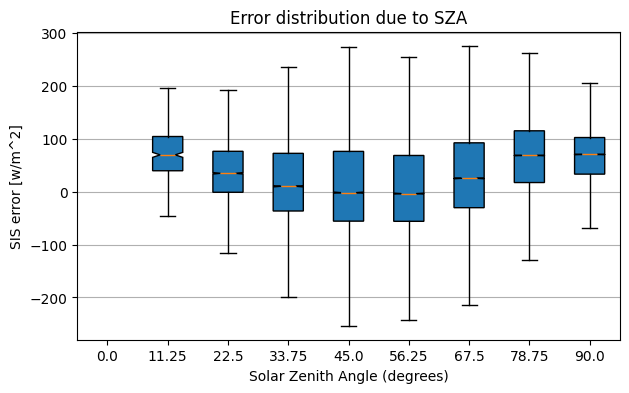

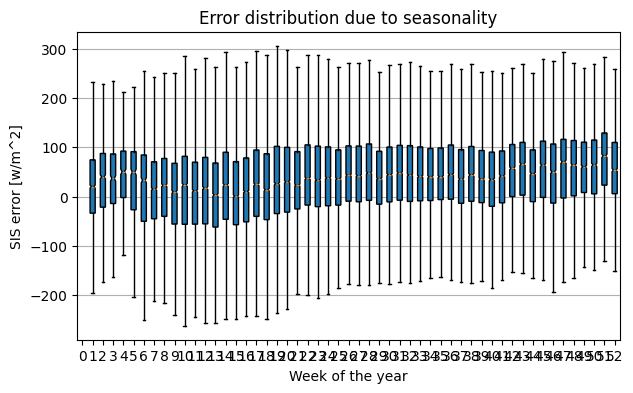

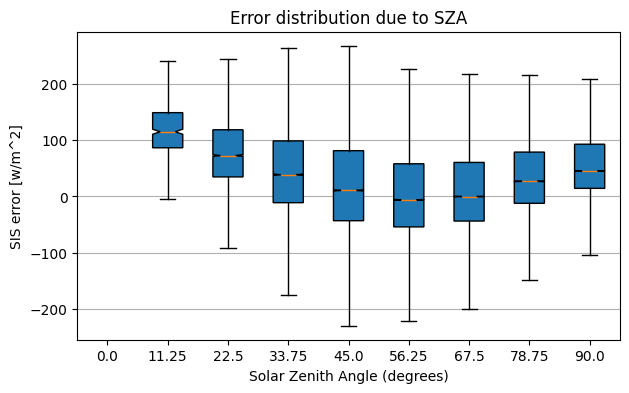

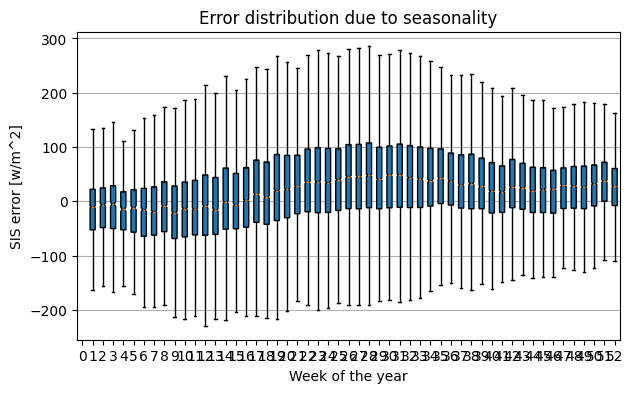

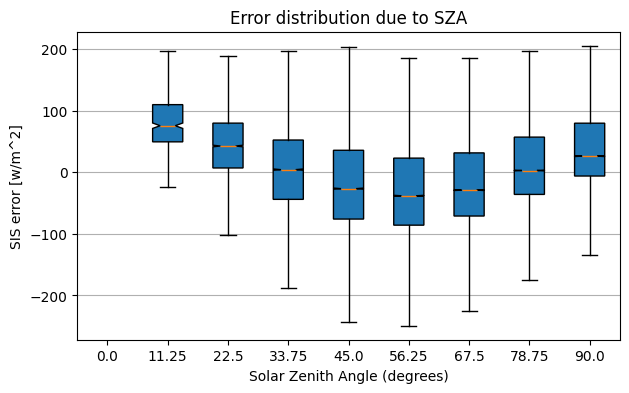

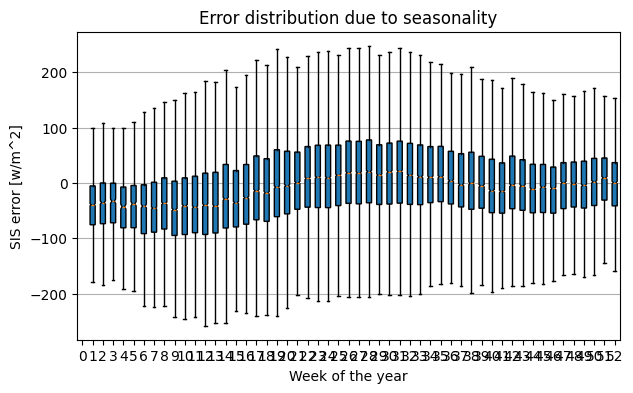

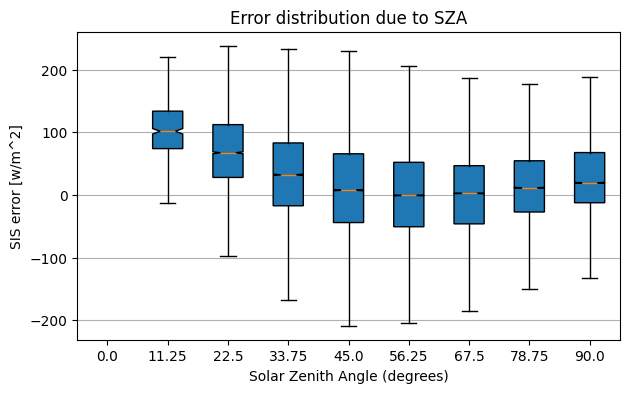

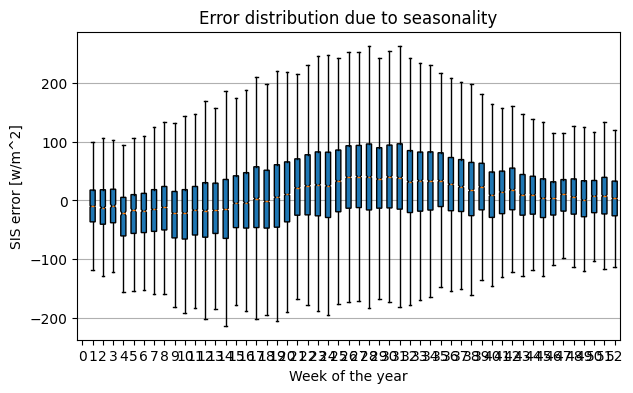

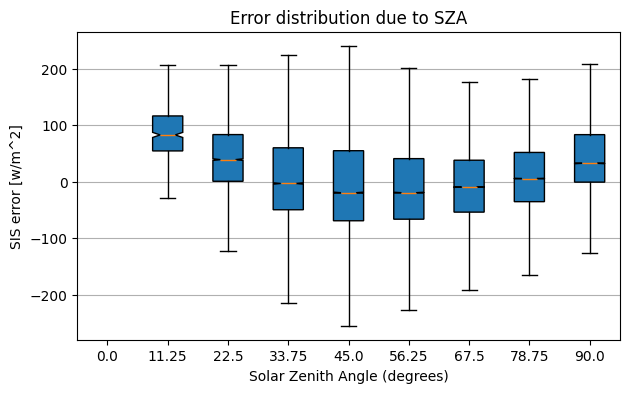

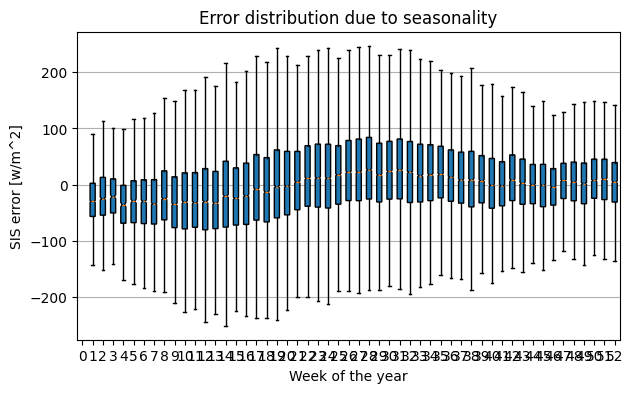

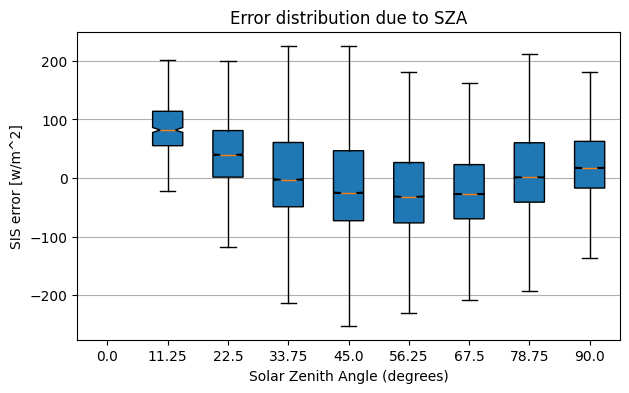

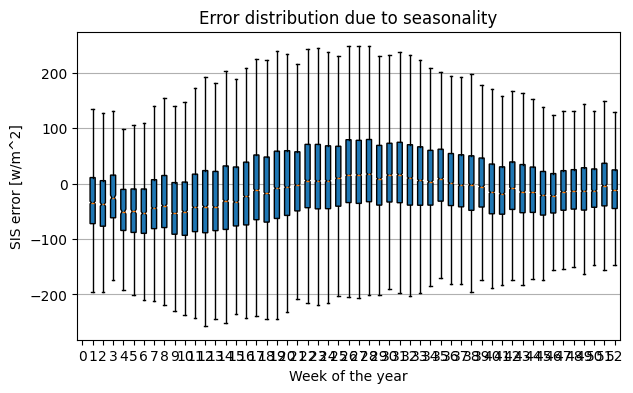

In [6]:
# trainer.validate(estimator, val_dataloader)
trainer.fit(
    estimator, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

In [156]:
seviri = train_dataloader.dataset.seviri
sarah = train_dataloader.dataset.sarah
solarpos = train_dataloader.dataset.solarpos
timeidx = train_dataloader.dataset.timeindices



In [157]:
seviri

<xarray.Dataset>
Dimensions:       (channel: 11, time: 222098, lat: 658, lon: 736)
Coordinates:
  * channel       (channel) <U10 'channel_3' 'channel_4' ... 'channel_6'
  * time          (time) datetime64[ns] 2015-12-31T23:45:00 ... 2022-12-31T23...
  * lon           (lon) float64 -7.775 -7.725 -7.675 ... 28.88 28.93 28.98
  * lat           (lat) float64 28.98 29.03 29.08 29.12 ... 61.73 61.78 61.83
Data variables:
    channel_data  (channel, time, lat, lon) float16 dask.array<chunksize=(11, 1, 658, 736), meta=np.ndarray>

In [139]:
import ephem

sun = ephem.Sun()
obs = ephem.Observer()
obs.lat = str(48)
obs.lon = str(0)
obs.elevation = 0

sun.compute(obs)
print(float(sun.alt))

0.9287350177764893


In [141]:
np.pi/2 - sun.alt

0.6420613090184073

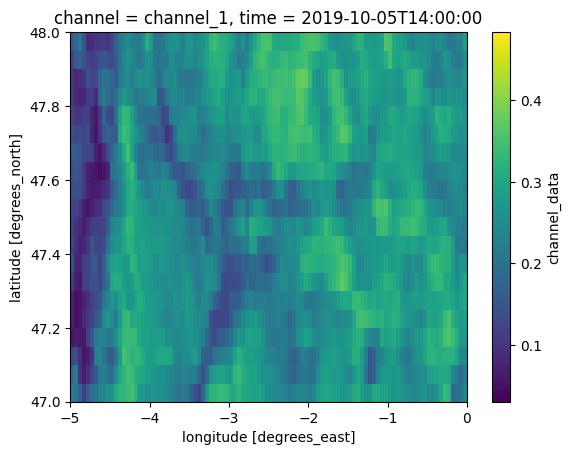

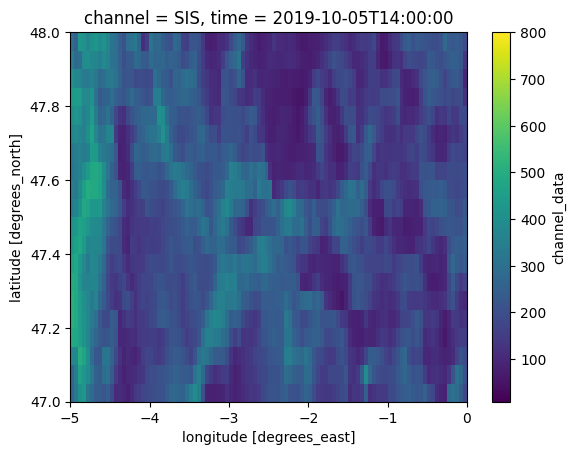

In [103]:
xlim = [-5, 0]
ylim = [47, 48]

seviri.channel_data.sel(channel='channel_1', time=timeidx[0]).plot.imshow(xlim=xlim, ylim=ylim)
plt.figure()
sarah.channel_data.sel(channel='SIS', time=timeidx[0]).plot.imshow(xlim=xlim, ylim=ylim)
plt.show()